
* Goal 2: Show overview of the network topologies
* Goal 3: Show overview of modifications of proteins in the interface of disease modules
* Goal 4: Show overview of the disease module overlap


- [ ] Show examples
- [ ] Create some disease modules
    - [X] Select multiform proteins
    - [ ] Select diseases containing multiforms
- [ ] A) Find pairs that overlap only with modified proteoforms
- [ ] B) Find pairs that overlap at gene/protein level and not overlap at proteoform level
    - [ ] Calculate overlap scores: node overlap, jaccard index, separation
    - [ ] Make
    - [ ] Plot overlap score distribution for all selected disease pairs
    - [ ] Plot selected pairs

## Set up configuration

In [1]:
import itertools
import random
import subprocess

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from numpy.core.tests.test_einsum import sizes

import config
from config import LEVELS, genes, proteins, proteoforms, GRAPHS_PATH, sm, no_sm, with_sm, with_unique_sm
from datasets.phegeni.filter_genes import create_filtered_file
from lib.dictionaries import read_dictionary_one_to_set, merge_dictionaries
from lib.download import download_if_not_exists
from lib.graph_database_access import get_query_result, get_participants, get_components
from lib.networks import get_or_create_interaction_network, print_interactome_details, get_nodes_and_adjacent
from queries import QUERY_GET_NUM_PROTEOFORMS_PER_PROTEIN
from visualization.visualize_single_network import plot_interaction_network, Coloring

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

config.set_root_wd()

Working directory: c:\git\pathwayanalysisplatform\proteoformnetworks


## Create disease modules

In [2]:
# PheGenI Phenotypes
download_if_not_exists("resources/PheGenI/", 
                       "PheGenI_Association.txt", 
                       "https://www.ncbi.nlm.nih.gov/projects/gap/eqtl/EpiViewBE.cgi?type=dl.tab",
                       "PheGenI All_modules")
print("PheGenI files READY")

# Filter
create_filtered_file("resources/PheGenI/PheGenI_Association.txt",
                     "resources/PheGenI/PheGenI_Association_genome_wide_significant.txt",
                     5e-8)

# Jensen Lab Diseases
download_if_not_exists("resources/Jensen/",
                       "human_disease_textmining_filtered.tsv",
                       "http://download.jensenlab.org/human_disease_textmining_filtered.tsv",
                       "Jensen Lab Diseases")
print("Jensen Lab files READY")

PheGenI files READY
Jensen Lab files READY


In [3]:
query = QUERY_GET_NUM_PROTEOFORMS_PER_PROTEIN
df = get_query_result(query)

df

,Protein,Proteoforms,NumProteoforms
0,P0CG48,"[[P0CG48], [P0CG48, 00134:152], [P0CG48, 00134...",82
1,P68431,"[[P68431], [P68431, 00046:11, 00047:12, 00064:...",52
2,Q71DI3,"[[Q71DI3], [Q71DI3, 00046:11, 00047:12, 00064:...",48
3,P02452,"[[P02452], [P02452, 00037:null], [P02452, 0003...",36
4,P08123,"[[P08123], [P08123, 00037:null], [P08123, 0003...",36
...,...,...,...
1486,Q9Y6K1,"[[Q9Y6K1], [Q9Y6K1, 01149:null]]",2
1487,Q9Y6Q2,"[[Q9Y6Q2], [Q9Y6Q2, 01150:null]]",2
1488,Q9Y6Q9,"[[Q9Y6Q9], [Q9Y6Q9, 00046:857]]",2
1489,Q9Y6W8,"[[Q9Y6W8-1], [Q9Y6W8-1, 00048:180]]",2


In [4]:
file_phegeni = "resources/PheGenI/PheGenI_Association_genome_wide_significant.txt"
df_diseases = pd.read_csv(file_phegeni, sep="\t")
df_diseases

,#,Trait,SNP rs,Context,Gene,Gene ID,Gene 2,Gene ID 2,Chromosome,Location,P-Value,Source,PubMed,Analysis ID,Study ID,Study Name
0,2,1-Alkyl-2-acetylglycerophosphocholine Esterase,7528419,UTR-3,CELSR2,1952,CELSR2,1952,1,109274569,0.00,NHGRI,22003152,0,NaN,NaN
1,3,1-Alkyl-2-acetylglycerophosphocholine Esterase,12740374,UTR-3,CELSR2,1952,CELSR2,1952,1,109274967,0.00,NHGRI,23118302,0,NaN,NaN
2,4,1-Alkyl-2-acetylglycerophosphocholine Esterase,599839,nearGene-3,PSRC1,84722,PSRC1,84722,1,109279543,0.00,NHGRI,20442857,0,NaN,NaN
3,5,1-Alkyl-2-acetylglycerophosphocholine Esterase,600550,intron,MS4A4E,643680,MS4A4E,643680,11,60230192,0.00,NHGRI,23118302,0,NaN,NaN
4,6,1-Alkyl-2-acetylglycerophosphocholine Esterase,964184,intron,ZPR1,8882,ZPR1,8882,11,116778200,0.00,NHGRI,22003152,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30210,136499,von Willebrand Factor,8176704,intron,ABO,28,ABO,28,9,133260147,0.00,NHGRI,26486471,0,NaN,NaN
30211,136500,von Willebrand Factor,687621,intron,ABO,28,ABO,28,9,133261661,0.00,NHGRI,20231535,0,NaN,NaN
30212,136501,von Willebrand Factor,643434,intron,ABO,28,ABO,28,9,133266941,0.00,NHGRI,23381943,0,NaN,NaN
30213,136502,von Willebrand Factor,505922,intron,ABO,28,ABO,28,9,133273812,0.00,NHGRI,23381943,0,NaN,NaN


In [5]:
map_disease_to_genes1 = read_dictionary_one_to_set("resources/PheGenI/", "PheGenI_Association_genome_wide_significant.txt", col_indices=(1, 4), ignore_header=True)
map_disease_to_genes2 = read_dictionary_one_to_set("resources/PheGenI/", "PheGenI_Association_genome_wide_significant.txt", col_indices=(1, 6), ignore_header=True)
df_diseases.columns
map_disease_to_genes = merge_dictionaries(map_disease_to_genes1, map_disease_to_genes2)
#map_disease_to_genes
print(f"Got map of {len(map_disease_to_genes.keys())} diseases to genes")

Got map of 873 diseases to genes


In [6]:
df_disease_to_genes = pd.DataFrame(data=[(d, len(g)) for d, g in map_disease_to_genes.items()], columns=["Disease", "Num"])
df_disease_to_genes['Entity'] = config.genes
df_disease_to_genes.sort_values(["Num"], ascending=False, inplace=True)
df_disease_to_genes

,Disease,Num,Entity
117,Body Mass Index,646,genes
637,Platelet Function Tests,594,genes
116,Body Height,520,genes
185,"Cholesterol, HDL",391,genes
109,Blood Pressure,331,genes
...,...,...,...
647,Premature Birth,1,genes
165,Caudate Nucleus,1,genes
169,Cerebral Amyloid Angiopathy,1,genes
243,Depression,1,genes


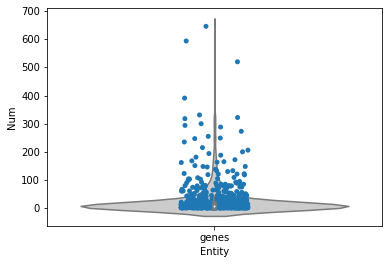

In [7]:
sns.violinplot(x="Entity", y="Num", data=df_disease_to_genes, color="0.8")
sns.stripplot(x="Entity", y="Num", data=df_disease_to_genes, jitter=True, zorder=1)
plt.show()

In [8]:
df_disease_to_genes = df_disease_to_genes[df_disease_to_genes['Num']<=100]
df_disease_to_genes

,Disease,Num,Entity
172,Cerebrospinal Fluid,99,genes
323,Fibrinogen,95,genes
549,Multiple Sclerosis,92,genes
220,Creatinine,92,genes
504,Macular Degeneration,90,genes
...,...,...,...
647,Premature Birth,1,genes
165,Caudate Nucleus,1,genes
169,Cerebral Amyloid Angiopathy,1,genes
243,Depression,1,genes


In [9]:
map_genes_to_proteins = read_dictionary_one_to_set(config.GRAPHS_PATH, "mapping_proteins_to_genes.tsv", col_indices=(1, 0))
df_genes_to_proteins = pd.DataFrame(data=[(g,len(ps)) for g, ps in map_genes_to_proteins.items()], columns=["Genes", "NumProteins"])
df_genes_to_proteins.sort_values(["NumProteins"], ascending=False, inplace=True)
df_genes_to_proteins

,Genes,NumProteins
830,HLA-B,36
831,HLA-A,21
833,HLA-C,14
3765,HLA-DRB1,13
4551,KIF5C,2
...,...,...
3665,TLE3,1
3666,TLE4,1
3667,TLE1,1
3668,KMT2D,1


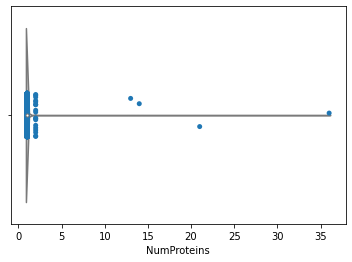

In [10]:
genes_arr=["Genes"]*len(df_genes_to_proteins)
sns.violinplot(x=df_genes_to_proteins["NumProteins"], color="0.8")
sns.stripplot(x=df_genes_to_proteins["NumProteins"], jitter=True, zorder=1)
plt.show()

In [11]:
filter_genes = df_genes_to_proteins[df_genes_to_proteins["NumProteins"] > 5]
filter_genes = set(filter_genes['Genes'])
filter_diseases = set()
for d, gs in map_disease_to_genes.items():
    if bool(gs & filter_genes):
        filter_diseases.add(d)
print(f"Diseases to delete: \n\n {filter_diseases}")
df_sel_diseases = df_disease_to_genes[~df_disease_to_genes['Disease'].isin(filter_diseases)]
df_sel_diseases


Diseases to delete: 

 {'Lymphocytes', 'Hepatitis B, Chronic', 'Anti-Neutrophil Cytoplasmic Antibody-Associated Vasculitis', 'Arthritis, Rheumatoid', 'Glomerulonephritis, IGA', 'Interferon-beta', 'Leprosy', 'Leukocytes', 'Multiple Sclerosis', 'Pulmonary Disease, Chronic Obstructive', 'Arthritis, Psoriatic', 'Tonsillectomy', 'Cholesterol', 'Nasopharyngeal Neoplasms', 'Epstein-Barr Virus Nuclear Antigens', 'Body Height', 'Menarche', 'Proteins', "Sjogren's Syndrome", 'Thioamides', 'Vaccine Potency', 'Behcet Syndrome', 'Breast Neoplasms', 'Cryoglobulinemia', 'Cholesterol, LDL', 'Drug Hypersensitivity Syndrome', 'Coronary Disease', 'Triglycerides', 'Lymphoma', 'Leukemia, Lymphocytic, Chronic, B-Cell', 'Lymphocyte Count', 'Uveomeningoencephalitic Syndrome', 'Thyroid Hormones', 'Antibodies', 'Otitis', 'Inflammatory Bowel Diseases', 'beta 2-Microglobulin', 'Hepatitis C, Chronic', 'Hodgkin Disease', 'Colitis, Ulcerative', 'Scleroderma, Systemic', 'Staphylococcus aureus', 'Epstein-Barr Virus Inf

,Disease,Num,Entity
172,Cerebrospinal Fluid,99,genes
323,Fibrinogen,95,genes
220,Creatinine,92,genes
504,Macular Degeneration,90,genes
424,"Influenza A Virus, H1N1 Subtype",89,genes
...,...,...,...
647,Premature Birth,1,genes
165,Caudate Nucleus,1,genes
169,Cerebral Amyloid Angiopathy,1,genes
243,Depression,1,genes


In [12]:
map_disease_to_proteins = {disease: set() for disease in df_sel_diseases["Disease"]}
for disease in df_sel_diseases["Disease"]:
    for g in map_disease_to_genes[disease]:
        if g in map_genes_to_proteins:
            for protein in map_genes_to_proteins[g]:
                map_disease_to_proteins[disease].add(protein)
#map_disease_to_proteins

In [13]:
map_disease_to_numproteins = {d: len(g) for d, g in map_disease_to_proteins.items()}
df_disease_to_proteins = pd.DataFrame(data=map_disease_to_numproteins.items(), columns=["Disease", "Num"])
df_disease_to_proteins['Entity'] = config.proteins
df_disease_to_proteins.sort_values(["Num"], ascending=False, inplace=True)
df_disease_to_proteins

,Disease,Num,Entity
3,Macular Degeneration,54,proteins
1,Fibrinogen,54,proteins
0,Cerebrospinal Fluid,51,proteins
6,Hematocrit,48,proteins
11,Hemoglobins,47,proteins
...,...,...,...
705,Neurofibrillary Tangles,0,proteins
647,Methadone,0,proteins
703,"Diet, High-Fat",0,proteins
648,"Memory, Episodic",0,proteins


In [14]:
df_disease_to_entitites = pd.concat([df_disease_to_genes, df_disease_to_proteins])
df_disease_to_entitites.sort_values(by=["Disease"], inplace=True)
df_disease_to_entitites

,Disease,Num,Entity
0,1-Alkyl-2-acetylglycerophosphocholine Esterase,13,genes
211,1-Alkyl-2-acetylglycerophosphocholine Esterase,8,proteins
1,3-hydroxy-1-methylpropylmercapturic acid,42,genes
64,3-hydroxy-1-methylpropylmercapturic acid,11,proteins
546,"ADAMTS13 protein, human",2,proteins
...,...,...,...
381,thyroid microsomal antibodies,2,proteins
871,von Willebrand Factor,14,genes
194,von Willebrand Factor,6,proteins
651,ziprasidone,1,proteins


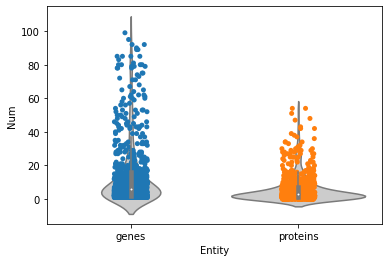

In [15]:
sns.violinplot(x="Entity", y="Num", data=df_disease_to_entitites, color="0.8")
sns.stripplot(x="Entity", y="Num", data=df_disease_to_entitites, jitter=True, zorder=1)
plt.show()

In [16]:
map_protein_to_diseases = {}
for d, ps in map_disease_to_proteins.items():
    for p in ps:
        if not p in map_protein_to_diseases.keys():
            map_protein_to_diseases[p] = set()
        map_protein_to_diseases[p].add(d)
#map_protein_to_diseases

In [17]:
map_protein_to_numdiseases = {p: len(ds) for p, ds in map_protein_to_diseases.items()}
df_p_nd = pd.DataFrame(data=map_protein_to_numdiseases.items(), columns=["Protein", "NumDiseases"])
df_p_nd.sort_values(["NumDiseases"], ascending=False, inplace=True)
df_p_nd

,Protein,NumDiseases
280,P16442,36
125,Q14397,31
295,O60427,24
192,P02654,23
265,Q9C0B1,15
...,...,...
1054,O15056,1
1053,P67936,1
1051,Q96K12,1
1050,Q9NZN3,1


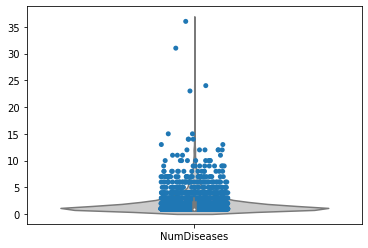

In [18]:
sns.violinplot(data=df_p_nd, color="0.8")
sns.stripplot(data=df_p_nd, jitter=True, zorder=1)
plt.show()

In [19]:
filter_proteins = df_p_nd[df_p_nd['NumDiseases'] > 10]
filter_proteins = set(filter_proteins["Protein"])
filter_proteins
filter_diseases = set()
for d, ps in map_disease_to_proteins.items():
    if bool(ps & filter_proteins):
        filter_diseases.add(d)
print(f"Diseases to delete: \n\n {filter_diseases}")
df_sel_diseases = df_disease_to_genes[~df_disease_to_genes['Disease'].isin(filter_diseases)]
df_sel_diseases


Diseases to delete: 

 {'Lymphoma, Follicular', 'Neoplasms', 'Intraocular Pressure', 'Carcinoma, Non-Small-Cell Lung', 'Gout', 'Lung Diseases, Interstitial', 'Cerebrospinal Fluid', 'Purines', 'docosapentaenoic acid', 'Corneal Topography', 'Adenocarcinoma of lung', 'Suntan', 'Anthropometry', 'Hematocrit', 'Duodenal Ulcer', 'Ovarian Neoplasms', 'Eosinophils', 'Graves Disease', 'Metabolic Syndrome X', 'Renal Insufficiency, Chronic', 'Common Variable Immunodeficiency', 'Wet Macular Degeneration', 'Cholangitis, Sclerosing', 'Multiple Myeloma', 'Phospholipids', 'hemoglobin A1c protein, human', 'Glioma', 'Angiotensins', 'Oropharyngeal Neoplasms', 'Insulin-Like Growth Factor I', 'E-Selectin', 'Trans Fatty Acids', 'Myopia', 'alpha-Linolenic Acid', 'Carcinoma, Endometrioid', 'Alopecia Areata', 'Lipids', 'Endometrial Neoplasms', 'Tumor Necrosis Factor-alpha', 'Linoleic Acid', 'Clinical Laboratory Techniques', 'Bipolar Disorder', 'Arterial Pressure', 'Vascular Calcification', 'Myocardial Infarctio

,Disease,Num,Entity
549,Multiple Sclerosis,92,genes
618,Parkinson Disease,89,genes
424,"Influenza A Virus, H1N1 Subtype",89,genes
588,Optic Disk,85,genes
245,"Dermatitis, Atopic",81,genes
...,...,...,...
647,Premature Birth,1,genes
165,Caudate Nucleus,1,genes
169,Cerebral Amyloid Angiopathy,1,genes
243,Depression,1,genes


In [20]:
# Select proteins with multiple proteoforms

selected_proteins = set(df["Protein"].unique())
selected_proteins

# Select proteins that do not participate in many diseases



{'P14921',
 'P08833',
 'Q5QNW6',
 'Q6UX39',
 'P22692',
 'Q9H4B6',
 'P15927',
 'Q76LX8',
 'P61764',
 'P41208',
 'P41235',
 'P10070',
 'Q92900',
 'Q8TDY2',
 'Q13324',
 'P56704',
 'Q06481',
 'Q13469',
 'Q9P283',
 'O43559',
 'P24385',
 'Q93098',
 'O43609',
 'P29320',
 'Q8TEB7',
 'Q6P5Z2',
 'Q96AX2',
 'O00204',
 'O95497',
 'O95477',
 'P19022',
 'Q03468',
 'Q03001',
 'P08631',
 'Q9Y6F9',
 'P02771',
 'P46527',
 'P46531',
 'Q969M7',
 'P35354',
 'P36896',
 'P19105',
 'Q6PEY2',
 'P01275',
 'Q9BUF5',
 'Q9NVI1',
 'P59190',
 'Q96PU8',
 'Q9Y6N5',
 'Q9Y4K3',
 'P40189',
 'Q13133',
 'P54764',
 'Q9NP71',
 'O75469',
 'Q8IXI2',
 'O00141',
 'P13611',
 'P23434',
 'P49448',
 'Q13285',
 'O43561',
 'Q14118',
 'P49023',
 'Q16777',
 'A6NHL2',
 'Q13885',
 'Q9NT62',
 'Q9BU40',
 'P20337',
 'Q12846',
 'P17480',
 'Q96GW7',
 'P01100',
 'P07949',
 'Q13976',
 'P03372',
 'Q5JZY3',
 'Q99541',
 'Q00534',
 'Q99715',
 'Q04726',
 'P61018',
 'Q99497',
 'Q01094',
 'Q04724',
 'Q7L523',
 'P43146',
 'Q8N4Z0',
 'O60353',
 'Q04721',

In [21]:
selected_diseases = set()
for disease, proteins in map_disease_to_proteins.items():
    if proteins & selected_proteins:
        selected_diseases.add(disease)
# selected_diseases
for i, val in enumerate(itertools.islice(selected_diseases, 10)):
    print(val)

Antidepressive Agents
Lung Diseases, Interstitial
Toluene 2,4-Diisocyanate
Cerebrospinal Fluid
Corneal Topography
Telomere
Eosinophils
Depressive Disorder
Metabolic Syndrome X
Renal Insufficiency, Chronic


In [22]:
len(selected_diseases)

321

In [23]:
participant_records = { l: get_participants(l, GRAPHS_PATH) for l in [*LEVELS, sm]}
components_records = { l: get_components(l, GRAPHS_PATH) for l in [*LEVELS, sm]}

In [24]:
interactomes_with_sm = { l: get_or_create_interaction_network(l, with_sm, participant_records, components_records, GRAPHS_PATH) for l in LEVELS}
for level, interactome in interactomes_with_sm.items():
     print_interactome_details(interactome)

KeyboardInterrupt: 

In [ ]:
# Create disease module at genes level
# -- We know what genes belong
# -- Create a subraph induced by the gene nodes and the neighboring small molecules

for trait in list(selected_diseases)[:1]:
    node_set = get_nodes_and_adjacent(map_disease_to_genes[trait], interactomes_with_sm[genes])
    S = interactomes_with_sm[genes].subgraph(node_set)
    p = plot_interaction_network(S, coloring=Coloring.ENTITY_TYPE, plot_width=600, plot_height=500, toolbar_location=None, title="Test title", legend_location="right")
    plt.show(p)
# Create disease module at proteins level

# Create disease module at proteoforms level